## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp006'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext50_32x4d'
    backbone = 'se_resnext101_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-5 / warmup_factor #1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 2 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

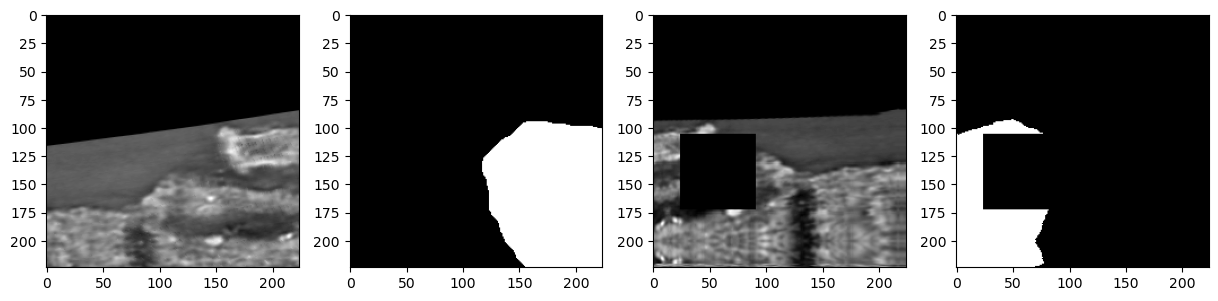

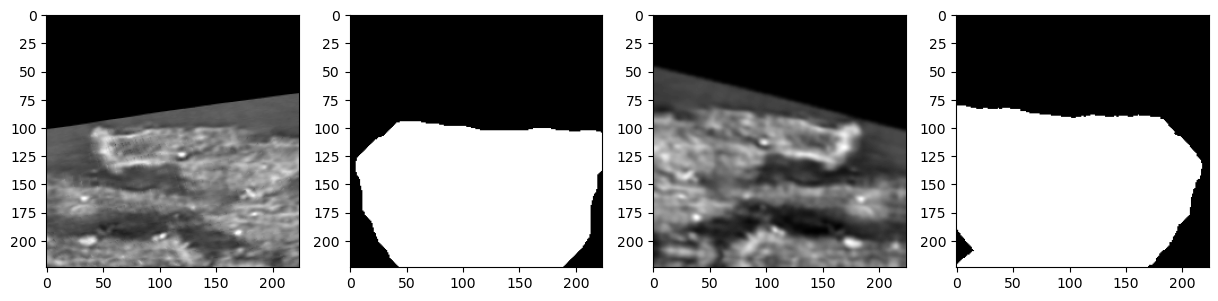

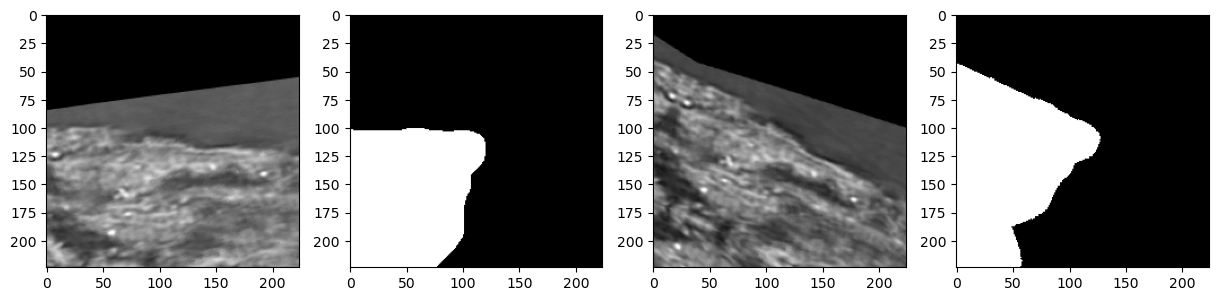

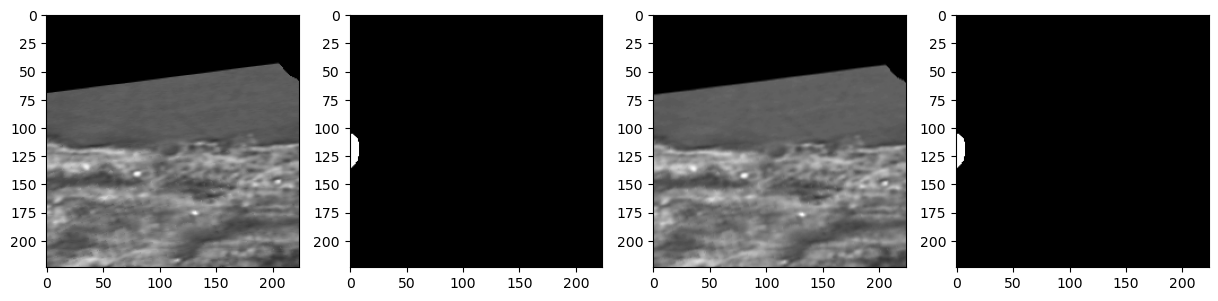

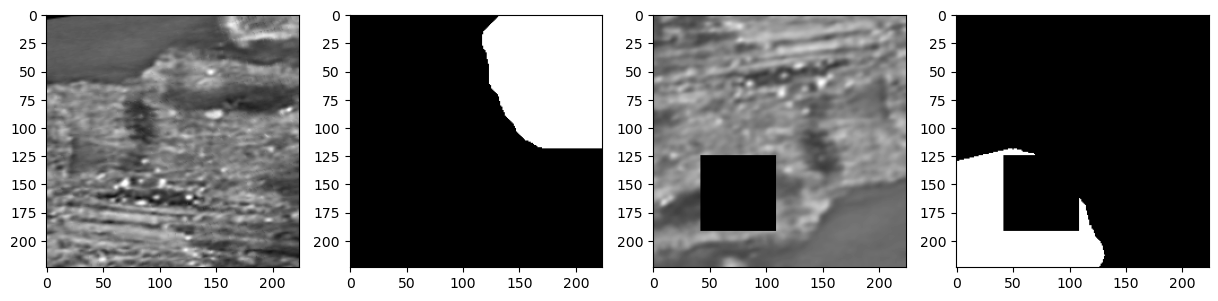

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48115

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext101_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.13782460665219384
th: 0.15, fbeta: 0.1355819636539841
th: 0.2, fbeta: 0.1342608828699285
th: 0.25, fbeta: 0.13694214224538834
th: 0.3, fbeta: 0.14699649528093
th: 0.35, fbeta: 0.16879351221234673
th: 0.4, fbeta: 0.18492705989376054
th: 0.45, fbeta: 0.18533050637416407


best_th: 0.45, fbeta: 0.18533050637416407
Epoch 1 - avg_train_loss: 0.5626  avg_val_loss: 0.5395  time: 162s
Epoch 1 - avgScore: 0.1853
Epoch 1 - Save Best Score: 0.1853 Model
Epoch 1 - Save Best Loss: 0.5395 Model


th: 0.5, fbeta: 0.1747587663523632


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.1402630230285062
th: 0.15, fbeta: 0.14038634475842396
th: 0.2, fbeta: 0.16072078168980639
th: 0.25, fbeta: 0.18850555400887492
th: 0.3, fbeta: 0.20414647732370292
th: 0.35, fbeta: 0.20826665480034787
th: 0.4, fbeta: 0.2077012044846119
th: 0.45, fbeta: 0.20267649578638255


best_th: 0.35, fbeta: 0.20826665480034787
Epoch 2 - avg_train_loss: 0.4798  avg_val_loss: 0.4898  time: 165s
Epoch 2 - avgScore: 0.2083
Epoch 2 - Save Best Score: 0.2083 Model
Epoch 2 - Save Best Loss: 0.4898 Model


th: 0.5, fbeta: 0.1884142637290836


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.14127814415999482
th: 0.15, fbeta: 0.15813857643441342
th: 0.2, fbeta: 0.22633770328115269
th: 0.25, fbeta: 0.24617491586462265
th: 0.3, fbeta: 0.26105222670328826
th: 0.35, fbeta: 0.26775819245546384
th: 0.4, fbeta: 0.25143601184409226
th: 0.45, fbeta: 0.1988007734761667


best_th: 0.35, fbeta: 0.26775819245546384
Epoch 3 - avg_train_loss: 0.3852  avg_val_loss: 0.3828  time: 167s
Epoch 3 - avgScore: 0.2678
Epoch 3 - Save Best Score: 0.2678 Model
Epoch 3 - Save Best Loss: 0.3828 Model


th: 0.5, fbeta: 0.12066742394258541


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.14204447060977576
th: 0.15, fbeta: 0.231188005484411
th: 0.2, fbeta: 0.25990097720685607
th: 0.25, fbeta: 0.27833886298074767
th: 0.3, fbeta: 0.2758407304116275
th: 0.35, fbeta: 0.24037647727743422
th: 0.4, fbeta: 0.18055817104441113
th: 0.45, fbeta: 0.11620584812259271


best_th: 0.25, fbeta: 0.27833886298074767
Epoch 4 - avg_train_loss: 0.3127  avg_val_loss: 0.3545  time: 166s
Epoch 4 - avgScore: 0.2783
Epoch 4 - Save Best Score: 0.2783 Model
Epoch 4 - Save Best Loss: 0.3545 Model


th: 0.5, fbeta: 0.06252253362469466


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.20425667561929098
th: 0.15, fbeta: 0.27021541913631497
th: 0.2, fbeta: 0.3082076357638881
th: 0.25, fbeta: 0.317859255052378
th: 0.3, fbeta: 0.2886635120416033
th: 0.35, fbeta: 0.232034770368038
th: 0.4, fbeta: 0.1674123745371076
th: 0.45, fbeta: 0.1089277583314618


best_th: 0.25, fbeta: 0.317859255052378
Epoch 5 - avg_train_loss: 0.2755  avg_val_loss: 0.3456  time: 166s
Epoch 5 - avgScore: 0.3179
Epoch 5 - Save Best Score: 0.3179 Model
Epoch 5 - Save Best Loss: 0.3456 Model


th: 0.5, fbeta: 0.06335586530604265


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.24077851872509043
th: 0.15, fbeta: 0.28661671882198464
th: 0.2, fbeta: 0.28208877349280886
th: 0.25, fbeta: 0.228768375326682
th: 0.3, fbeta: 0.15892160245577888
th: 0.35, fbeta: 0.1007303389435738
th: 0.4, fbeta: 0.05984616098229764
th: 0.45, fbeta: 0.03251838871413


best_th: 0.15, fbeta: 0.28661671882198464
Epoch 6 - avg_train_loss: 0.2518  avg_val_loss: 0.3504  time: 167s
Epoch 6 - avgScore: 0.2866


th: 0.5, fbeta: 0.015849827950068153


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.27928791490030114
th: 0.15, fbeta: 0.32068910765635983
th: 0.2, fbeta: 0.29453214544926853
th: 0.25, fbeta: 0.2301780729313649
th: 0.3, fbeta: 0.1661631732706675
th: 0.35, fbeta: 0.11463414059510224
th: 0.4, fbeta: 0.07371973185080988
th: 0.45, fbeta: 0.04393305078444759


best_th: 0.15, fbeta: 0.32068910765635983
Epoch 7 - avg_train_loss: 0.2316  avg_val_loss: 0.3544  time: 166s
Epoch 7 - avgScore: 0.3207
Epoch 7 - Save Best Score: 0.3207 Model
Epoch 7 - Save Best Loss: 0.3544 Model


th: 0.5, fbeta: 0.02486590788200323


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2892332282184871
th: 0.15, fbeta: 0.31365243438864643
th: 0.2, fbeta: 0.2750674869725647
th: 0.25, fbeta: 0.21358088234323933
th: 0.3, fbeta: 0.15572487631422544
th: 0.35, fbeta: 0.11001269997966467
th: 0.4, fbeta: 0.07708285527245415
th: 0.45, fbeta: 0.052857051501765465


best_th: 0.15, fbeta: 0.31365243438864643
Epoch 8 - avg_train_loss: 0.2156  avg_val_loss: 0.3556  time: 168s
Epoch 8 - avgScore: 0.3137


th: 0.5, fbeta: 0.034348335898098395


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32185991199467684
th: 0.15, fbeta: 0.3179973797734201
th: 0.2, fbeta: 0.2592248339512313
th: 0.25, fbeta: 0.19112482930870758
th: 0.3, fbeta: 0.13271841070538914
th: 0.35, fbeta: 0.08675567545398863
th: 0.4, fbeta: 0.05451442164482993
th: 0.45, fbeta: 0.034666712542180865


best_th: 0.1, fbeta: 0.32185991199467684
Epoch 9 - avg_train_loss: 0.2060  avg_val_loss: 0.3649  time: 165s
Epoch 9 - avgScore: 0.3219
Epoch 9 - Save Best Score: 0.3219 Model
Epoch 9 - Save Best Loss: 0.3649 Model


th: 0.5, fbeta: 0.02332420007061892


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3542449906339084
th: 0.15, fbeta: 0.3699245258574888
th: 0.2, fbeta: 0.34399369525628476
th: 0.25, fbeta: 0.2982099741246196
th: 0.3, fbeta: 0.24905504729474476
th: 0.35, fbeta: 0.20259183535592143
th: 0.4, fbeta: 0.16080108398545018
th: 0.45, fbeta: 0.12543919067694725


best_th: 0.15, fbeta: 0.3699245258574888
Epoch 10 - avg_train_loss: 0.1984  avg_val_loss: 0.3570  time: 167s
Epoch 10 - avgScore: 0.3699
Epoch 10 - Save Best Score: 0.3699 Model
Epoch 10 - Save Best Loss: 0.3570 Model


th: 0.5, fbeta: 0.09437410805935548


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3609553264901482
th: 0.15, fbeta: 0.35030277873865057
th: 0.2, fbeta: 0.3110196179286161
th: 0.25, fbeta: 0.2651956909730287
th: 0.3, fbeta: 0.21942222981683687
th: 0.35, fbeta: 0.1753599933848763
th: 0.4, fbeta: 0.13726726630177422
th: 0.45, fbeta: 0.10535120125261935


best_th: 0.1, fbeta: 0.3609553264901482
Epoch 11 - avg_train_loss: 0.1905  avg_val_loss: 0.3803  time: 165s
Epoch 11 - avgScore: 0.3610


th: 0.5, fbeta: 0.07836421177967577


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3694343463902962
th: 0.15, fbeta: 0.3457509235710677
th: 0.2, fbeta: 0.2930085982371936
th: 0.25, fbeta: 0.23684117287733522
th: 0.3, fbeta: 0.18614459474218453
th: 0.35, fbeta: 0.1433902337086345
th: 0.4, fbeta: 0.10613702351164989
th: 0.45, fbeta: 0.07643668166420818


best_th: 0.1, fbeta: 0.3694343463902962
Epoch 12 - avg_train_loss: 0.1843  avg_val_loss: 0.3823  time: 163s
Epoch 12 - avgScore: 0.3694


th: 0.5, fbeta: 0.05359398741333981


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3650511033984981
th: 0.15, fbeta: 0.34690105758425294
th: 0.2, fbeta: 0.3025566095284166
th: 0.25, fbeta: 0.25280108035020094
th: 0.3, fbeta: 0.20499228765805874
th: 0.35, fbeta: 0.16329494257978777
th: 0.4, fbeta: 0.1251584309754638
th: 0.45, fbeta: 0.09333503759279334


best_th: 0.1, fbeta: 0.3650511033984981
Epoch 13 - avg_train_loss: 0.1765  avg_val_loss: 0.3778  time: 162s
Epoch 13 - avgScore: 0.3651


th: 0.5, fbeta: 0.06998559650056702


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33654887953787954
th: 0.15, fbeta: 0.3068557554046223
th: 0.2, fbeta: 0.2655130164085422
th: 0.25, fbeta: 0.22140279480297806
th: 0.3, fbeta: 0.18235398017447083
th: 0.35, fbeta: 0.14789002909897275
th: 0.4, fbeta: 0.11450632602766189
th: 0.45, fbeta: 0.08708039457777858


best_th: 0.1, fbeta: 0.33654887953787954
Epoch 14 - avg_train_loss: 0.1734  avg_val_loss: 0.3956  time: 163s
Epoch 14 - avgScore: 0.3365


th: 0.5, fbeta: 0.06601003953807713


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3497262116269021
th: 0.15, fbeta: 0.3120755865409697
th: 0.2, fbeta: 0.2656718595714084
th: 0.25, fbeta: 0.21729803772218648
th: 0.3, fbeta: 0.17469767089824717
th: 0.35, fbeta: 0.13850345301634714
th: 0.4, fbeta: 0.10918755977609046
th: 0.45, fbeta: 0.08410098903042965


best_th: 0.1, fbeta: 0.3497262116269021
Epoch 15 - avg_train_loss: 0.1646  avg_val_loss: 0.4130  time: 163s
Epoch 15 - avgScore: 0.3497


th: 0.5, fbeta: 0.06249338783734185


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36012321240694933
th: 0.15, fbeta: 0.3435366363743109
th: 0.2, fbeta: 0.31379145152027443
th: 0.25, fbeta: 0.2803188337855916
th: 0.3, fbeta: 0.24530450452080246
th: 0.35, fbeta: 0.2082529356704416
th: 0.4, fbeta: 0.1700386974406695
th: 0.45, fbeta: 0.13692010243275415


best_th: 0.1, fbeta: 0.36012321240694933
Epoch 16 - avg_train_loss: 0.1613  avg_val_loss: 0.3976  time: 163s
Epoch 16 - avgScore: 0.3601


th: 0.5, fbeta: 0.10888969622265945


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3593583596910678
th: 0.15, fbeta: 0.3400453178290679
th: 0.2, fbeta: 0.310173254371352
th: 0.25, fbeta: 0.27527883122634095
th: 0.3, fbeta: 0.24015240810579083
th: 0.35, fbeta: 0.20745846007509458
th: 0.4, fbeta: 0.17517664243503642
th: 0.45, fbeta: 0.14357936018407041


best_th: 0.1, fbeta: 0.3593583596910678
Epoch 17 - avg_train_loss: 0.1569  avg_val_loss: 0.4205  time: 162s
Epoch 17 - avgScore: 0.3594


th: 0.5, fbeta: 0.1145172561729713


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3516127389007586
th: 0.15, fbeta: 0.33618956277735645
th: 0.2, fbeta: 0.30835029982026213
th: 0.25, fbeta: 0.273815848466278
th: 0.3, fbeta: 0.23918445884132328
th: 0.35, fbeta: 0.20605829771103965
th: 0.4, fbeta: 0.17381553478000186
th: 0.45, fbeta: 0.14292243806769386


best_th: 0.1, fbeta: 0.3516127389007586
Epoch 18 - avg_train_loss: 0.1556  avg_val_loss: 0.4182  time: 162s
Epoch 18 - avgScore: 0.3516


th: 0.5, fbeta: 0.11359607264676394


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3586189269651055
th: 0.15, fbeta: 0.34572369287958743
th: 0.2, fbeta: 0.3215900534280028
th: 0.25, fbeta: 0.28945847871821556
th: 0.3, fbeta: 0.2522034586574155
th: 0.35, fbeta: 0.21367813151298742
th: 0.4, fbeta: 0.17780091313822477
th: 0.45, fbeta: 0.14415302492732227


best_th: 0.1, fbeta: 0.3586189269651055
Epoch 19 - avg_train_loss: 0.1517  avg_val_loss: 0.4086  time: 163s
Epoch 19 - avgScore: 0.3586


th: 0.5, fbeta: 0.1119000949686966


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34689615896004794
th: 0.15, fbeta: 0.3199726272448968
th: 0.2, fbeta: 0.287838177130778
th: 0.25, fbeta: 0.2520651970878081
th: 0.3, fbeta: 0.215584934591127
th: 0.35, fbeta: 0.18085358358807996
th: 0.4, fbeta: 0.1503511308880027
th: 0.45, fbeta: 0.12205111683304051


best_th: 0.1, fbeta: 0.34689615896004794
Epoch 20 - avg_train_loss: 0.1491  avg_val_loss: 0.4232  time: 161s
Epoch 20 - avgScore: 0.3469


th: 0.5, fbeta: 0.09569457412364972


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3447867022353019
th: 0.15, fbeta: 0.3229860862475416
th: 0.2, fbeta: 0.29168079290294163
th: 0.25, fbeta: 0.25410424401160364
th: 0.3, fbeta: 0.21858028348291023
th: 0.35, fbeta: 0.18518950393396275
th: 0.4, fbeta: 0.1528732609596346
th: 0.45, fbeta: 0.12188106203243153


best_th: 0.1, fbeta: 0.3447867022353019
Epoch 21 - avg_train_loss: 0.1446  avg_val_loss: 0.4351  time: 163s
Epoch 21 - avgScore: 0.3448


th: 0.5, fbeta: 0.09359402216111165


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33593951778744735
th: 0.15, fbeta: 0.31085357644022177
th: 0.2, fbeta: 0.28103588572730215
th: 0.25, fbeta: 0.24578976289036536
th: 0.3, fbeta: 0.21238742163892946
th: 0.35, fbeta: 0.18196023274654616
th: 0.4, fbeta: 0.15323016834359882
th: 0.45, fbeta: 0.1264621364766393


best_th: 0.1, fbeta: 0.33593951778744735
Epoch 22 - avg_train_loss: 0.1448  avg_val_loss: 0.4435  time: 162s
Epoch 22 - avgScore: 0.3359


th: 0.5, fbeta: 0.10109126893291005


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3412258936611071
th: 0.15, fbeta: 0.31525018257543447
th: 0.2, fbeta: 0.2800217427572445
th: 0.25, fbeta: 0.2411443476095449
th: 0.3, fbeta: 0.20532597624900933
th: 0.35, fbeta: 0.17053472163417693
th: 0.4, fbeta: 0.13822128897860553
th: 0.45, fbeta: 0.10958861585004213


best_th: 0.1, fbeta: 0.3412258936611071
Epoch 23 - avg_train_loss: 0.1441  avg_val_loss: 0.4389  time: 163s
Epoch 23 - avgScore: 0.3412


th: 0.5, fbeta: 0.08473822019259493


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3464147541817055
th: 0.15, fbeta: 0.32500155424915345
th: 0.2, fbeta: 0.29778768918231807
th: 0.25, fbeta: 0.2657757558964675
th: 0.3, fbeta: 0.23408328445171764
th: 0.35, fbeta: 0.20293067421076166
th: 0.4, fbeta: 0.17147478073747935
th: 0.45, fbeta: 0.14143124594937193


best_th: 0.1, fbeta: 0.3464147541817055
Epoch 24 - avg_train_loss: 0.1409  avg_val_loss: 0.4509  time: 162s
Epoch 24 - avgScore: 0.3464


th: 0.5, fbeta: 0.11387801955407711


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32670762507481915
th: 0.15, fbeta: 0.2881925505839404
th: 0.2, fbeta: 0.2477624953675328
th: 0.25, fbeta: 0.20879718231421762
th: 0.3, fbeta: 0.1730600246572989
th: 0.35, fbeta: 0.14078311117161765
th: 0.4, fbeta: 0.11196765971275952
th: 0.45, fbeta: 0.08582876385230107


best_th: 0.1, fbeta: 0.32670762507481915
Epoch 25 - avg_train_loss: 0.1377  avg_val_loss: 0.4615  time: 163s
Epoch 25 - avgScore: 0.3267


th: 0.5, fbeta: 0.06412071561563058


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3438019314941987
th: 0.15, fbeta: 0.3316305257384947
th: 0.2, fbeta: 0.3122980861744444
th: 0.25, fbeta: 0.2868923097013135
th: 0.3, fbeta: 0.25689037902468614
th: 0.35, fbeta: 0.22779509209161386
th: 0.4, fbeta: 0.19829739756427617
th: 0.45, fbeta: 0.16869234935495894


best_th: 0.1, fbeta: 0.3438019314941987
Epoch 26 - avg_train_loss: 0.1390  avg_val_loss: 0.4266  time: 162s
Epoch 26 - avgScore: 0.3438


th: 0.5, fbeta: 0.14047507424440586


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3404501392322502
th: 0.15, fbeta: 0.3247578076437528
th: 0.2, fbeta: 0.30238183909693767
th: 0.25, fbeta: 0.27303449058128904
th: 0.3, fbeta: 0.2421722652650684
th: 0.35, fbeta: 0.21123902093414867
th: 0.4, fbeta: 0.18120688551538477
th: 0.45, fbeta: 0.15085872795223054


best_th: 0.1, fbeta: 0.3404501392322502
Epoch 27 - avg_train_loss: 0.1365  avg_val_loss: 0.4527  time: 162s
Epoch 27 - avgScore: 0.3405


th: 0.5, fbeta: 0.1229583519267813


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32797712493844206
th: 0.15, fbeta: 0.2978982861418157
th: 0.2, fbeta: 0.26114266197100366
th: 0.25, fbeta: 0.22403181284762122
th: 0.3, fbeta: 0.19003338420584903
th: 0.35, fbeta: 0.16061143001277345
th: 0.4, fbeta: 0.13275866090137145
th: 0.45, fbeta: 0.10557611213186403


best_th: 0.1, fbeta: 0.32797712493844206
Epoch 28 - avg_train_loss: 0.1372  avg_val_loss: 0.4688  time: 162s
Epoch 28 - avgScore: 0.3280


th: 0.5, fbeta: 0.07944088720357381


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33528631378572477
th: 0.15, fbeta: 0.31504370012390204
th: 0.2, fbeta: 0.288353702862872
th: 0.25, fbeta: 0.25506312029917494
th: 0.3, fbeta: 0.22109497826757232
th: 0.35, fbeta: 0.19045003928281795
th: 0.4, fbeta: 0.16143448784859388
th: 0.45, fbeta: 0.1311846956430783


best_th: 0.1, fbeta: 0.33528631378572477
Epoch 29 - avg_train_loss: 0.1377  avg_val_loss: 0.4533  time: 162s
Epoch 29 - avgScore: 0.3353


th: 0.5, fbeta: 0.10398849395972055


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34139594218506975
th: 0.15, fbeta: 0.32412650464943776
th: 0.2, fbeta: 0.2999051132602798
th: 0.25, fbeta: 0.26854068038563117
th: 0.3, fbeta: 0.23666949450791003
th: 0.35, fbeta: 0.20581904248021057
th: 0.4, fbeta: 0.1768070021664283
th: 0.45, fbeta: 0.14873817022764174


best_th: 0.1, fbeta: 0.34139594218506975
Epoch 30 - avg_train_loss: 0.1350  avg_val_loss: 0.4511  time: 161s
Epoch 30 - avgScore: 0.3414


th: 0.5, fbeta: 0.1210223883270456


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.3542449906339084
th: 0.15, fbeta: 0.3699245258574888
th: 0.2, fbeta: 0.34399369525628476
th: 0.25, fbeta: 0.2982099741246196
th: 0.3, fbeta: 0.24905504729474476
th: 0.35, fbeta: 0.20259183535592143
th: 0.4, fbeta: 0.16080108398545018
th: 0.45, fbeta: 0.12543919067694725


best_th: 0.15, fbeta: 0.3699245258574888


th: 0.5, fbeta: 0.09437410805935548


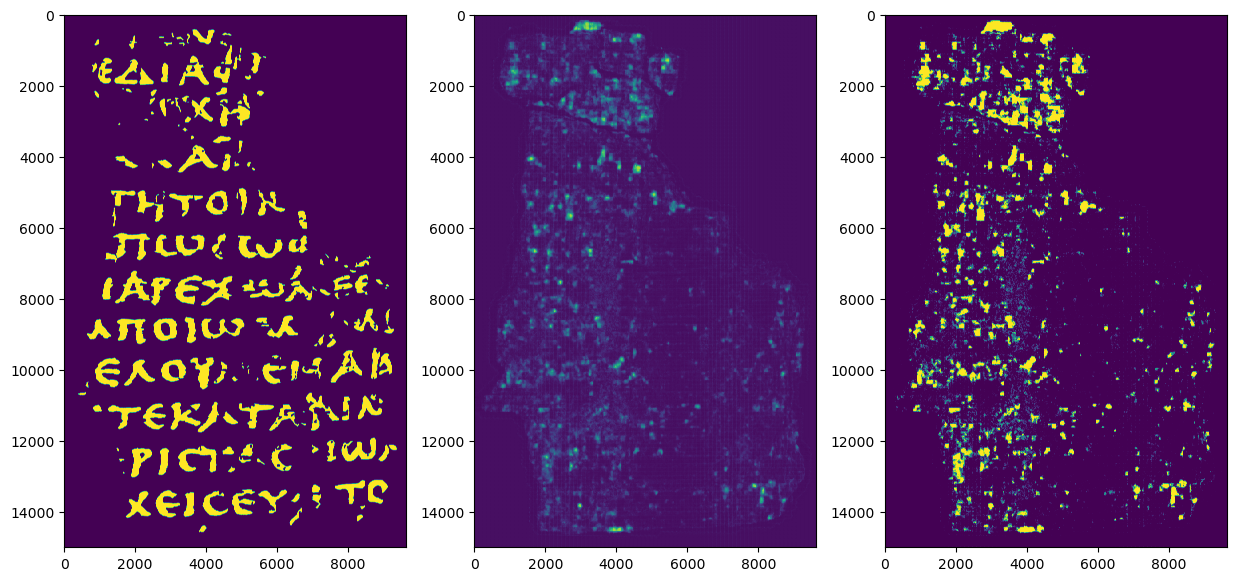

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([8.3832375e+07, 3.8821729e+07, 1.0344534e+07, 4.4511120e+06,
        2.4119480e+06, 1.4417380e+06, 9.1982100e+05, 6.2972700e+05,
        4.4694400e+05, 3.2420200e+05, 2.4643800e+05, 1.9833200e+05,
        1.4399500e+05, 1.1021700e+05, 9.1030000e+04, 6.3230000e+04,
        4.7722000e+04, 2.9617000e+04, 2.2720000e+03, 7.3000000e+01]),
 array([1.25912617e-04, 4.46537556e-02, 8.91815985e-02, 1.33709441e-01,
        1.78237284e-01, 2.22765127e-01, 2.67292970e-01, 3.11820813e-01,
        3.56348656e-01, 4.00876499e-01, 4.45404342e-01, 4.89932185e-01,
        5.34460028e-01, 5.78987871e-01, 6.23515714e-01, 6.68043557e-01,
        7.12571400e-01, 7.57099243e-01, 8.01627086e-01, 8.46154929e-01,
        8.90682772e-01]),
 <BarContainer object of 20 artists>)

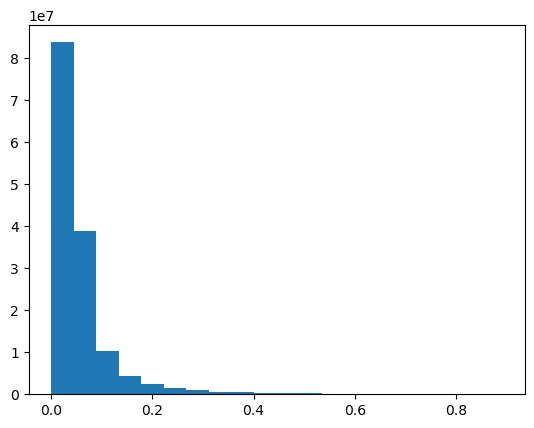

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000